In [1]:
!pip install statsmodels==0.14.5
!pip install matplotlib==3.10.3
!pip install sklearn==0.0
!pip install hurst==0.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 125.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 161.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1342 sha256=ab42880944c15837125a3468578a78caee67d6e252c9c3aecc7aa241b5c3c2c7
  Stored in directory: /root/.cache/pip/wheels/b6/79/d0/1f349fd7f2d799c2260c1be479f993c546f3045238876a00f0
Successfully built sklearn

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new 

In [2]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from dateutil.parser import parse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from hurst import compute_Hc
import os
from datetime import date, datetime, timedelta

In [3]:
# Import Data
df = pd.read_csv('NVD-Vulnerability-Volumes.csv', index_col=['Publication'], low_memory=False)
df.index = pd.to_datetime(df.index, errors='coerce')  # Convert index to datetime, handling errors
df['Count'] = 1

# Ensure 'v2 Vector' and 'v3 Vector' are of type object
df['v2 Vector'] = df['v2 Vector'].astype('object')
df['v3 Vector'] = df['v3 Vector'].astype('object')

df.tail()

,ID,ASSIGNER,DESCRIPTION,v2 CVSS,v2 Exploitability Score,v2 Vector,v3 CVSS,v3 Vector,v3 Exploitability Score,v2.3 CPE,CWE,VulnStatus,Count
Publication,,,,,,,,,,,,,
2025-09-26 03:15:44.380,CVE-2025-60029,psirt@fortinet.com,Rejected reason: Not used,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,Rejected,1
2025-09-26 03:15:44.450,CVE-2025-60030,psirt@fortinet.com,Rejected reason: Not used,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,Rejected,1
2025-09-26 03:15:44.520,CVE-2025-60031,psirt@fortinet.com,Rejected reason: Not used,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,Rejected,1
2025-09-26 03:15:44.590,CVE-2025-60032,psirt@fortinet.com,Rejected reason: Not used,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,Rejected,1
2025-09-26 03:15:44.663,CVE-2025-60033,psirt@fortinet.com,Rejected reason: Not used,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,Rejected,1


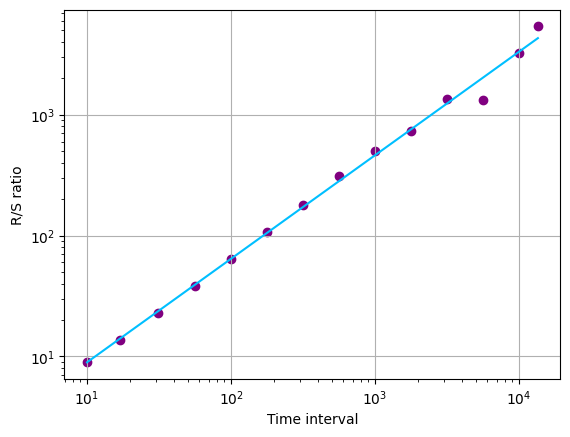

H=0.8574, c=1.2382


In [4]:
# Fixing the issue by ensuring the 'Publication' column is properly parsed as datetime and handling NaT values.
# Drop rows with NaT in the 'Publication' index
hurst_df = df.dropna(subset=['Count'])

# Resample the data to daily frequency and sum the counts
daily_counts = hurst_df['Count'].resample('D').sum()

# Drop NaN values after resampling
daily_counts = daily_counts.dropna()

# Compute the Hurst component
H, c, data = compute_Hc(daily_counts, kind='change', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data[0], c * data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H, c))

In [5]:
stationary = adfuller(df['Count'].resample('Y').sum().to_list())

/tmp/ipykernel_9739/1275241850.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  stationary = adfuller(df['Count'].resample('Y').sum().to_list())


In [6]:
stationary

(2.6708200085357907,
 0.9990849202000855,
 10,
 27,
 {'1%': -3.6996079738860943,
  '5%': -2.9764303469999494,
  '10%': -2.627601001371742},
 510.6362580330676)

In [7]:
diff_stationary = adfuller(np.diff(df['Count'].resample('Y').sum().to_list(),n=1))

/tmp/ipykernel_9739/4019195330.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  diff_stationary = adfuller(np.diff(df['Count'].resample('Y').sum().to_list(),n=1))


In [8]:
diff_stationary

(-0.31108464672008274,
 0.9239196766778776,
 7,
 29,
 {'1%': -3.6790595944893187,
  '5%': -2.9678817237279103,
  '10%': -2.6231583472057074},
 497.72154175793105)

In [9]:
cutoff = datetime(datetime.now().year-1, 12, 31, 0, 0) 
#We'll want to check our progress through the quarter so we do need that as a data set later
check=df[df.index.tz_localize(None)>cutoff]
df=df[df.index.tz_localize(None)<=cutoff]
# Construct the model
mod = sm.tsa.SARIMAX(df['Count'].resample('Y').sum(), order=(1, 2, 1), trend='ct')
# Estimate the parameters
res = mod.fit(method="powell",maxiter=500,full_output=True)
print(res.summary())

/tmp/ipykernel_9739/3054221309.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  mod = sm.tsa.SARIMAX(df['Count'].resample('Y').sum(), order=(1, 2, 1), trend='ct')
Optimization terminated successfully.
         Current function value: 8.656645
         Iterations: 7
         Function evaluations: 395
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                   37
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -320.296
Date:                Fri, 26 Sep 2025   AIC                            650.592
Time:                        11:21:38   BIC                            658.368
Sample:                    12-31-1988   HQIC                           653.276
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
         

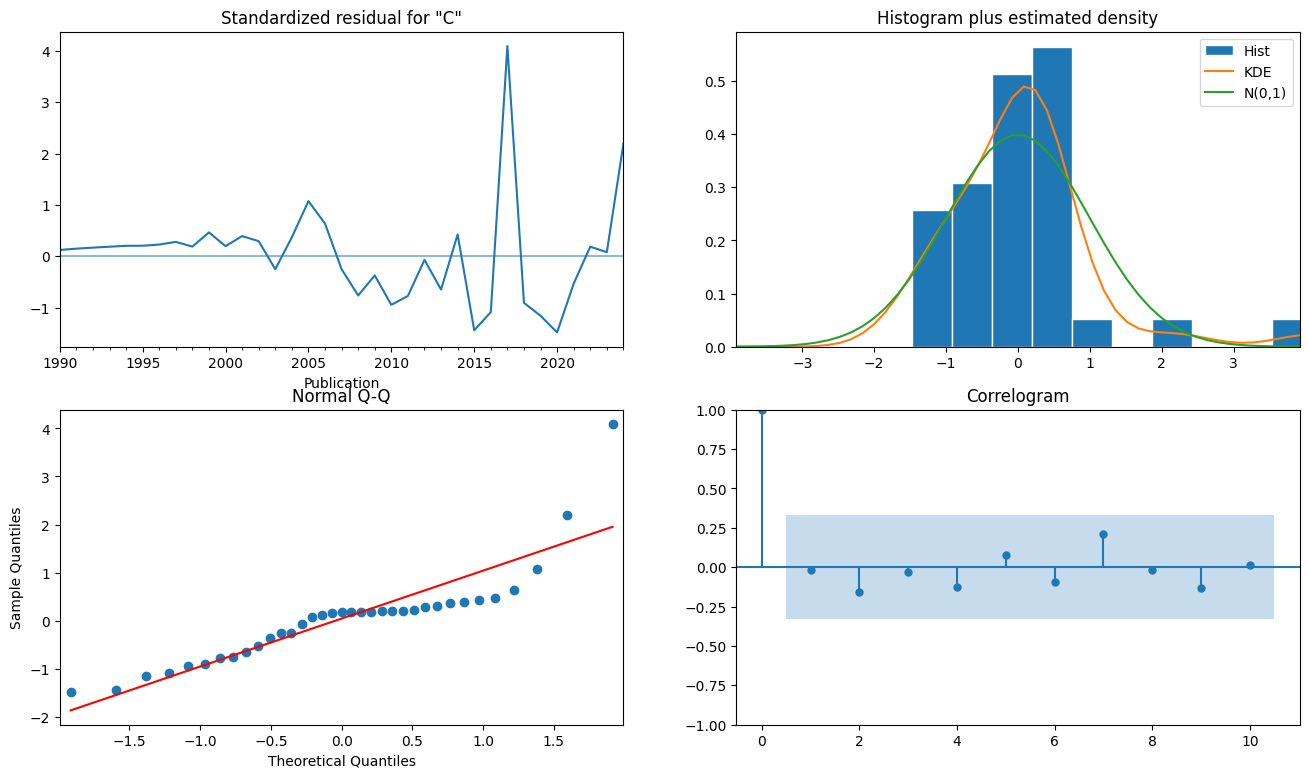

In [10]:
# Plot diagnostics
res.plot_diagnostics(figsize=(16, 9))
plt.show()

In [11]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(steps=11)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print(fcast_res1.summary_frame(alpha=0.05))

Count                mean      mean_se  mean_ci_lower  mean_ci_upper
2025-12-31   45504.748665  2225.994334   41141.879940   49867.617390
2026-12-31   51299.336293  3050.859198   45319.762142   57278.910443
2027-12-31   57503.973165  3734.869333   50183.763785   64824.182544
2028-12-31   64178.782748  4336.097173   55680.188456   72677.377040
2029-12-31   71336.079226  4885.927905   61759.836501   80912.321951
2030-12-31   78992.402465  5400.024635   68408.548665   89576.256266
2031-12-31   87163.918840  5887.760231   75624.120838   98703.716843
2032-12-31   95866.827737  6355.206507   83410.851869  108322.803604
2033-12-31  105117.325623  6806.544954   91776.742654  118457.908592
2034-12-31  114931.609225  7244.786675  100732.088265  129131.130184
2035-12-31  125325.875245  7672.176295  110288.686024  140363.064466


In [12]:
today = date.today()
current_datetime = today.strftime("%b-%d-%Y")
#Note this format will overwrite all forecasts produced on the same day
file_name = current_datetime+"-Yearly-vuln4cast.csv"
path = 'YearlyForecasts/'
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new directory is created!")
fcast_res1.summary_frame(alpha=0.05).to_csv(path+file_name)

In [13]:
#Last year's count
df.resample('YE').Count.sum().iloc[-1]

40601

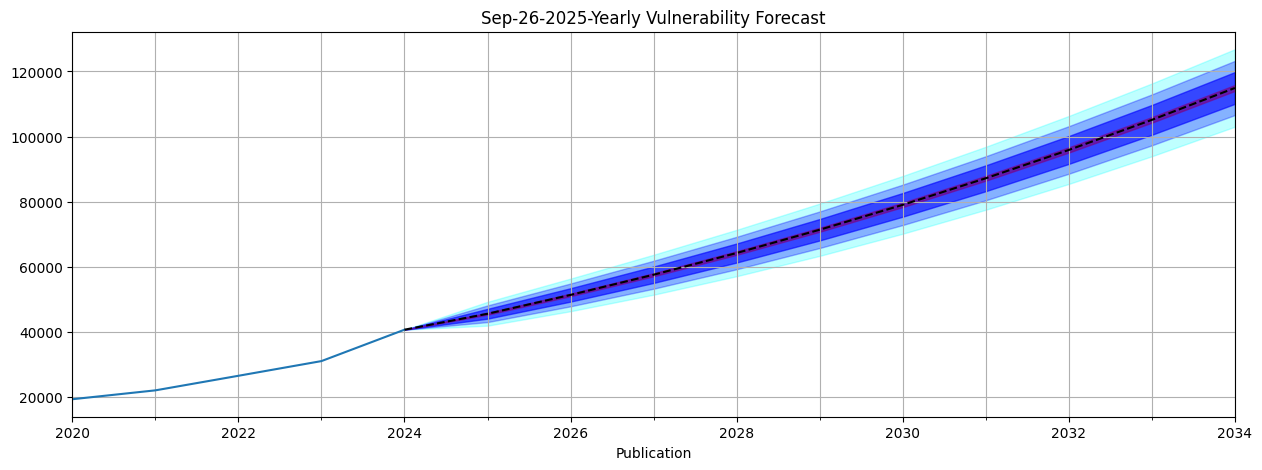

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.title(current_datetime+"-Yearly Vulnerability Forecast")

# Plot the data (here we are subsetting it to get a closer look at the forecasts than the history)
df['Count'].resample('YE').sum().loc[str(today.year-5):].plot(ax=ax)

# Construct the forecasts
fcast_10 = res.get_forecast(steps=10).summary_frame(alpha=0.10)
fcast_25 = res.get_forecast(steps=10).summary_frame(alpha=0.25)
fcast_50 = res.get_forecast(steps=10).summary_frame(alpha=0.50)
fcast_90 = res.get_forecast(steps=10).summary_frame(alpha=0.90)

# Add a row to the forecast that shows the current numbers and has equal ci
# This makes the display a little nicer to read (eliminating an interstitial space)
interstitial_date = fcast_10.index[0]-timedelta(days=366)
interstitial_date = interstitial_date.tz_localize(None)

new_row = pd.DataFrame(
    {'mean':df.resample('YE').Count.sum().iloc[-1], 
     'mean_se':fcast_10.mean_se.iloc[0], 
     'mean_ci_lower':df.resample('YE').Count.sum().iloc[-1], 
     'mean_ci_upper':df.resample('YE').Count.sum().iloc[-1]}, 
    index=[interstitial_date])

fcast_10 = pd.concat([new_row,fcast_10.loc[:]])

new_row = pd.DataFrame(
    {'mean':df.resample('YE').Count.sum().iloc[-1], 
     'mean_se':fcast_25.mean_se.iloc[0], 
     'mean_ci_lower':df.resample('YE').Count.sum().iloc[-1], 
     'mean_ci_upper':df.resample('YE').Count.sum().iloc[-1]}, 
    index=[interstitial_date])

fcast_25 = pd.concat([new_row,fcast_25.loc[:]])

new_row = pd.DataFrame(
    {'mean':df.resample('YE').Count.sum().iloc[-1], 
     'mean_se':fcast_50.mean_se.iloc[0], 
     'mean_ci_lower':df.resample('YE').Count.sum().iloc[-1], 
     'mean_ci_upper':df.resample('YE').Count.sum().iloc[-1]}, 
    index=[interstitial_date])


fcast_50 = pd.concat([new_row,fcast_50.loc[:]])

new_row = pd.DataFrame(
    {'mean':df.resample('YE').Count.sum().iloc[-1], 
     'mean_se':fcast_90.mean_se.iloc[0], 
     'mean_ci_lower':df.resample('YE').Count.sum().iloc[-1], 
     'mean_ci_upper':df.resample('YE').Count.sum().iloc[-1]}, 
    index=[interstitial_date])

fcast_90 = pd.concat([new_row,fcast_90.loc[:]])

fcast_10['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast_10.index, fcast_10['mean_ci_lower'], fcast_10['mean_ci_upper'], color='cyan', alpha=0.25, label='90% Prediction Interval')
ax.fill_between(fcast_25.index, fcast_25['mean_ci_lower'], fcast_25['mean_ci_upper'], color='blue', alpha=0.30, label='75% Prediction Interval')
ax.fill_between(fcast_50.index, fcast_50['mean_ci_lower'], fcast_50['mean_ci_upper'], color='blue', alpha=0.60, label='50% Prediction Interval')
ax.fill_between(fcast_90.index, fcast_90['mean_ci_lower'], fcast_90['mean_ci_upper'], color='purple', alpha=0.60, label='10% Prediction Interval')
ax.grid(which='both')
image_name = current_datetime+"-Yearly-vuln4cast.png"
plt.savefig(path+image_name)

In [15]:
interstitial_date

Timestamp('2024-12-30 00:00:00')

In [16]:
#Now check how we're doing so far...
print(fcast_res1.summary_frame(alpha=0.05))
print('The current count of published NVD vulns is: '+str(check['Count'].sum()))
print('The current difference is: '+str(check['Count'].sum()- fcast_res1.summary_frame()['mean'].iloc[0]))

Count                mean      mean_se  mean_ci_lower  mean_ci_upper
2025-12-31   45504.748665  2225.994334   41141.879940   49867.617390
2026-12-31   51299.336293  3050.859198   45319.762142   57278.910443
2027-12-31   57503.973165  3734.869333   50183.763785   64824.182544
2028-12-31   64178.782748  4336.097173   55680.188456   72677.377040
2029-12-31   71336.079226  4885.927905   61759.836501   80912.321951
2030-12-31   78992.402465  5400.024635   68408.548665   89576.256266
2031-12-31   87163.918840  5887.760231   75624.120838   98703.716843
2032-12-31   95866.827737  6355.206507   83410.851869  108322.803604
2033-12-31  105117.325623  6806.544954   91776.742654  118457.908592
2034-12-31  114931.609225  7244.786675  100732.088265  129131.130184
2035-12-31  125325.875245  7672.176295  110288.686024  140363.064466
The current count of published NVD vulns is: 36425
The current difference is: -9079.748664939354


In [17]:
mean_v2_vector_forecast = fcast_res1.summary_frame()['mean'].iloc[0]*df['v2 Vector'].dropna().value_counts(normalize=True)
lowerci_v2_vector_forecast = fcast_res1.summary_frame()['mean_ci_lower'].iloc[0]*df['v2 Vector'].dropna().value_counts(normalize=True)
upperci_v2_vector_forecast = fcast_res1.summary_frame()['mean_ci_upper'].iloc[0]*df['v2 Vector'].dropna().value_counts(normalize=True)

In [18]:
#Assemble them and save to csv

In [19]:
mean_v2_vector_forecast.sum()

45504.74866493935

In [20]:
upperci_v2_vector_forecast.sum()

49867.617389806204

In [21]:
lowerci_v2_vector_forecast.sum()

41141.87994007251

In [22]:
mean_v2_vector_forecast.to_csv(path+current_datetime+'-MeanV2VectorForecast.csv')
upperci_v2_vector_forecast.to_csv(path+current_datetime+'-UpperCIV2VectorForecast.csv')
lowerci_v2_vector_forecast.to_csv(path+current_datetime+'-LowerCIV2VectorForecast.csv')

In [23]:
# The error occurs because there are float values (likely NaN) in the 'v3 Vector' column.
# We need to handle these cases explicitly in the functions.

def remove_cvss_prefix(vector):
    if isinstance(vector, str) and vector.startswith("CVSS:3."):
        return vector[8+1:]
    return vector

def remove_double_quotes(input_string):
    if isinstance(input_string, str):
        return input_string.replace('"', '')
    return input_string

# Apply the updated functions to the 'v3 Vector' column
df['v3 Vector'] = df['v3 Vector'].apply(remove_double_quotes)
df['v3 Vector'] = df['v3 Vector'].apply(remove_cvss_prefix)

In [24]:
mean_v3_vector_forecast = fcast_res1.summary_frame()['mean'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)
lowerci_v3_vector_forecast = fcast_res1.summary_frame()['mean_ci_lower'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)
upperci_v3_vector_forecast = fcast_res1.summary_frame()['mean_ci_upper'].iloc[0]*df['v3 Vector'].dropna().value_counts(normalize=True)

In [25]:
mean_v3_vector_forecast

v3 Vector
AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H    4815.294178
AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N    2495.847301
AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H    2176.577114
AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H    2171.231647
AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H    2026.418077
                                          ...     
AV:L/AC:L/PR:H/UI:R/S:U/C:L/I:N/A:H       0.242976
AV:P/AC:H/PR:N/UI:N/S:C/C:L/I:H/A:N       0.242976
AV:L/AC:L/PR:N/UI:R/S:C/C:L/I:H/A:L       0.242976
AV:N/AC:H/PR:H/UI:N/S:C/C:N/I:L/A:L       0.242976
AV:P/AC:L/PR:N/UI:R/S:U/C:H/I:L/A:L       0.242976
Name: proportion, Length: 1650, dtype: float64

In [26]:
mean_v3_vector_forecast.to_csv(path+current_datetime+'-Yearly-MeanV3VectorForecast.csv')
upperci_v3_vector_forecast.to_csv(path+current_datetime+'-Yearly-UpperCIV3VectorForecast.csv')
lowerci_v3_vector_forecast.to_csv(path+current_datetime+'-Yearly-LowerCIV3VectorForecast.csv')

In [27]:
#This should be improved, from a multiplication to a forecast for each one
simple_assigner_forecast = fcast_res1.summary_frame()['mean'].iloc[0]*df['ASSIGNER'].value_counts(normalize=True)

In [28]:
simple_assigner_forecast

ASSIGNER
cve@mitre.org                           17867.594116
secalert@redhat.com                      1922.197888
secure@microsoft.com                     1853.412140
secalert_us@oracle.com                   1330.243614
security-advisories@github.com           1191.183964
                                            ...     
info@greenrocketsecurity.com                0.165350
secure@ea.com                               0.165350
1d66c9f9-fff2-411a-aa19-ca6312fa25e9        0.165350
9947ef80-c5d5-474a-bbab-97341a59000e        0.165350
cb7ba516-3b07-4c98-b0c2-715220f1a8f6        0.165350
Name: proportion, Length: 361, dtype: float64

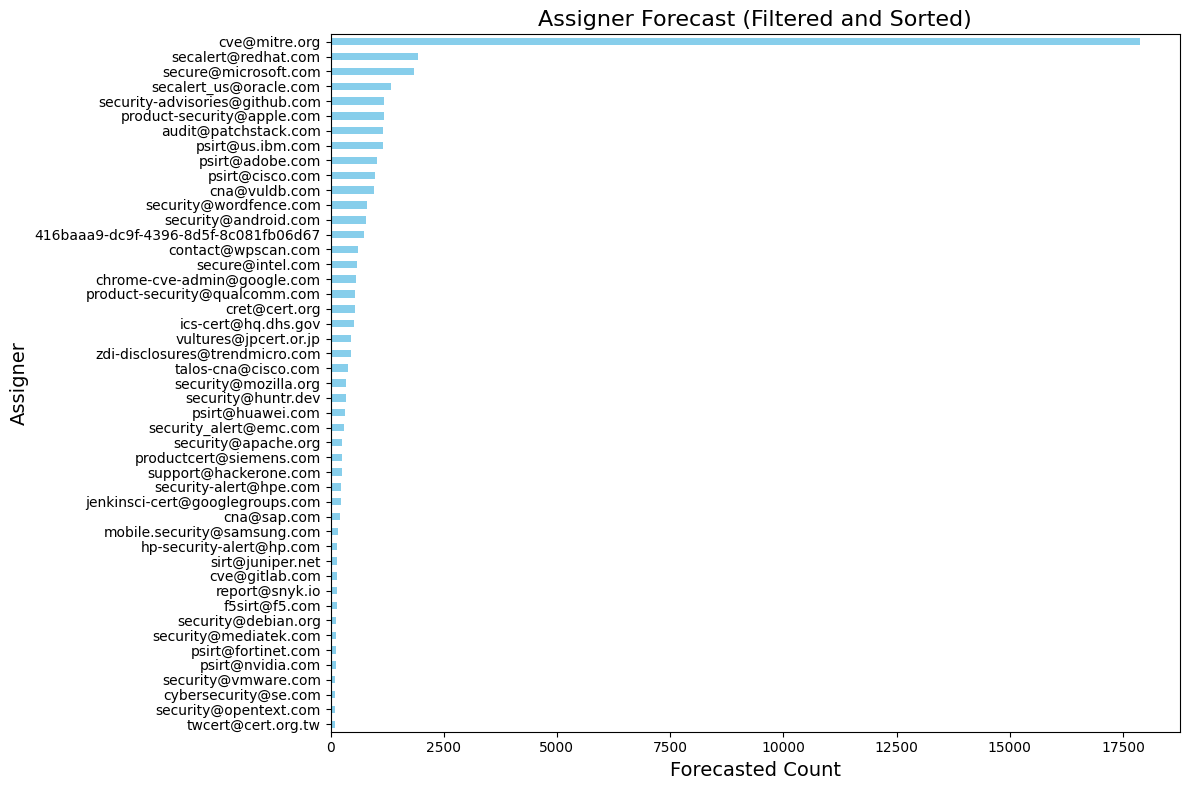

In [29]:
import matplotlib.pyplot as plt

# Filter assigners with values greater than or equal to 100
filtered_assigner_forecast = simple_assigner_forecast[simple_assigner_forecast >= 100]

# Sort the filtered data in descending order
sorted_assigner_forecast = filtered_assigner_forecast.sort_values(ascending=False)

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
sorted_assigner_forecast.plot(kind='barh', color='skyblue')
plt.title('Assigner Forecast (Filtered and Sorted)', fontsize=16)
plt.xlabel('Forecasted Count', fontsize=14)
plt.ylabel('Assigner', fontsize=14)
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest at the top
plt.tight_layout()
plt.show()

In [30]:
v3_CVSS_Score_Forecast = fcast_res1.summary_frame()['mean'].iloc[0]*df['v3 CVSS'].value_counts(normalize=True)

In [31]:
check['v3 Vector'] = check['v3 Vector'].apply(remove_double_quotes)
check['v3 Vector'] = check['v3 Vector'].apply(remove_cvss_prefix)
actual = check['v3 Vector'].value_counts()

In [32]:
predicted = mean_v3_vector_forecast

In [33]:
if len(actual) > 0: 
    verify_v3_vector = pd.merge(predicted, actual, left_index=True, right_index=True, validate="1:1")
    verify_v3_vector = verify_v3_vector.rename(columns={"v3 Vector_x": "Predicted", "v3 Vector_y": "Actual"})
else:
    verify_v3_vector = predicted

In [34]:
verify_v3_vector.head(20)

,proportion,count
v3 Vector,,
AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,4815.294178,1774
AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N,2495.847301,798
AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,2176.577114,702
AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,2171.231647,944
AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,2026.418077,800
AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,1871.399524,407
AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,1637.899791,1118
AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,1622.349340,606
AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,1614.088164,666


In [35]:
verify_v3_vector[verify_v3_vector['count'] > verify_v3_vector.proportion]

,proportion,count
v3 Vector,,
AV:N/AC:L/PR:L/UI:N/S:U/C:L/I:L/A:L,526.771510,1140
AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:L/A:N,490.568117,751
AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,355.230603,770
AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:L/A:N,326.073508,364
AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:L,319.513162,1048
...,...,...
AV:L/AC:H/PR:N/UI:N/S:C/C:N/I:H/A:H,0.242976,4
AV:L/AC:H/PR:N/UI:N/S:C/C:L/I:L/A:N,0.242976,5
AV:L/AC:L/PR:H/UI:R/S:C/C:H/I:L/A:L,0.242976,1


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7acd54e3-f1e9-4bb5-a625-0a781a5b944c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>